## Imports y dependencias

In [1]:
import os
import subprocess
import logging
from google.cloud import bigquery, storage
import google.auth

import copy
import requests
import json
import math
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna
import shap
shap.plots.initjs()
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="shap")

# from ydata_profiling import ProfileReport

import re
import joblib
import time
from datetime import timedelta
from tqdm.notebook import tqdm

from xgboost import XGBClassifier
from tabpfn import TabPFNClassifier

from scipy.stats import uniform, randint
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
 
credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)
 
#nuevo
# Make clients.
bqclient = bigquery.Client(project=os.environ.get("CLOUD_ML_PROJECT_ID"))
bqstorageclient = storage.Client(project=os.environ.get("CLOUD_ML_PROJECT_ID"))

### Funciones desarrolladas

In [2]:
# función para imprimir las métricas ROC AUC y LIFT
def evaluar_modelo(y_true, y_pred_proba, top_percentiles=[1, 5, 10]):
    """
    Calcula ROC AUC y LIFT en los percentiles indicados (por defecto 1%, 5%, 10%).
    
    Args:
        y_true: array-like, etiquetas reales (0 o 1) -el target-
        y_pred_proba: array-like, probabilidades predichas para la clase positiva
        top_percentiles: lista de percentiles a evaluar para el Lift

    Returns:
        None (imprime las métricas)
    """
    # Crear DataFrame ordenado por score
    df = pd.DataFrame({
        "y_true": y_true,
        "y_score": y_pred_proba
    }).sort_values(by="y_score", ascending=False).reset_index(drop=True)

    # ROC AUC
    auc = roc_auc_score(df["y_true"], df["y_score"])
    print(f"\tROC AUC: {auc:.4f}")

    # Tasa base (porcentaje de positivos en todo el dataset)
    tasa_base = df["y_true"].mean()
    
    lifts = {}
    # Calcular Lift en cada top X%
    for p in top_percentiles: #top_percentiles=[1, 5, 10]
        corte = int(len(df) * p / 100)
        top_df = df.iloc[:corte]
        tasa_top = top_df["y_true"].mean()
        lift = tasa_top / tasa_base if tasa_base > 0 else 0
        lifts[p]=lift
        print(f"\tLift @ top {p}%: {lift:.2f}x")
    return auc, lifts


def entrenamiento_iterativo(
    X_train_pl, y_train,
    X_val_pl, y_val,
    evaluar_modelo,
    modelo_base=None,
    umbral=None,
    lift_percentiles=[1, 5, 10],
    verbose=True
):
    """
    Ejecuta entrenamiento iterativo eliminando variables menos importantes, usando Polars como entrada.

    Parámetros:
        X_train_pl (pl.DataFrame): Features para entrenamiento
        y_train (pd.Series): Target de entrenamiento
        X_val_pl (pl.DataFrame): Features para validación interna (early stopping)
        y_val (pd.Series): Target de validación interna
        evaluar_modelo (func): Función que recibe (y_test, y_pred_proba, top_percentiles=...) y devuelve (auc, lifts)
        modelo_base (XGBClassifier): Modelo ya optimizado con hiperparámetros (por ejemplo, search.best_estimator_)
        umbral (float): Umbral de caída del AUC
        lift_percentiles (list): Percentiles para calcular lift
        verbose (bool): Imprimir progreso

    Devuelve:
        df_metrics: DataFrame Polars con historial de métricas
        variables_borradas: Lista de variables eliminadas
        variables_finales: Lista de variables restantes
    """

    
    mejor_auc = -1
    metrics_hist = []
    variables_borradas = []

    X_work = X_train_pl.clone()
    X_val_work = X_val_pl.clone()

    start_time = time.time()

    while X_work.shape[1] > 1:
        now_time = time.time()
        duracion = timedelta(seconds=now_time - start_time)

        if verbose:
            print(f"-- Entrenamiento con {X_work.shape[1]} variables -- ⏱️ {duracion}")

        # Convertir a pandas para XGBoost
        X_train_pd = X_work.to_pandas()
        X_val_pd = X_val_work.to_pandas()

        # Instanciar nuevo modelo (para que se reinicie el early stopping en cada ronda)
        if modelo_base is not None:
            modelo = copy.deepcopy(modelo_base)
        else:
            modelo = XGBClassifier(
                n_estimators=300,
                random_state=42
            )

        modelo.fit(
            X_train_pd, y_train,
            verbose=False
        )

        y_pred_proba = modelo.predict_proba(X_val_pd)[:, 1]
        auc, lifts = evaluar_modelo(y_val, y_pred_proba, top_percentiles=lift_percentiles)

        metric_row = {
            "n_features": X_work.shape[1],
            "roc_auc": auc
        }
        for p in lift_percentiles:
            metric_row[f"lift@{p}%"] = lifts.get(p, None)
        metrics_hist.append(metric_row)

        if umbral is not None:
            if mejor_auc == -1:
                mejor_auc = auc
            elif auc < mejor_auc - umbral:
                if verbose:
                    print(f"🔴 AUC cayó por debajo del umbral permitido: {auc:.4f} < {mejor_auc - umbral:.4f}")
                break
            else:
                mejor_auc = max(mejor_auc, auc)

        # Importancia de variables
        importancias = modelo.feature_importances_
        df_importancia = pd.DataFrame({
            "caracteristica": X_work.columns,
            "importancia": importancias
        }).sort_values(by="importancia", ascending=True)

        var_borrar = df_importancia.iloc[0]["caracteristica"]
        if verbose:
            print(f"\t🗑️ Eliminando variable: {var_borrar} - Importancia: {df_importancia.iloc[0]['importancia']:.5f}")

        # Eliminar la variable menos importante
        X_work = X_work.drop(var_borrar)
        X_val_work = X_val_work.drop(var_borrar)
        variables_borradas.append(var_borrar)

    df_metrics = pl.DataFrame(metrics_hist)
    variables_finales = X_work.columns

    return df_metrics, variables_borradas, variables_finales

def predict_en_batches(modelo, X, batch_size=512):
    probas = []
    n = len(X)

    for i in tqdm(range(0, n, batch_size), desc="Procesando batches de entrenamiento para TabPFN"):
        batch = X.iloc[i:i+batch_size]
        probas_batch = modelo.predict_proba(batch)[:, 1]
        probas.extend(probas_batch)

    return np.array(probas)

def recuperar_columnas(variables_finales, variables_borradas, num_variables=100):
    """
    Devuelve una lista de columnas seleccionadas que incluye las variables finales 
    y, si es necesario, algunas de las variables eliminadas para completar el total deseado.

    - variables_finales: lista de columnas que no fueron eliminadas
    - variables_borradas: lista de columnas eliminadas (en orden de eliminación)
    - num_variables: número total de columnas deseadas

    Retorna:
        columnas_seleccionadas: lista final de columnas
    """
    n_a_recuperar = num_variables - len(variables_finales)
    ultimas_recuperadas = variables_borradas[-n_a_recuperar:] if n_a_recuperar > 0 else []
    columnas_seleccionadas = variables_finales + ultimas_recuperadas[::-1]
    return columnas_seleccionadas


#Funciones de PLOTS
def graficar_metricas_entrenamiento(df_metrics, lift_percentiles=[1, 5, 10], zoom=False):
    """
    Genera gráficos de evolución del ROC AUC y Lifts durante el entrenamiento iterativo.

    Parámetros:
        df_metrics (pl.DataFrame): Historial de métricas por iteración
        lift_percentiles (list): Lista de percentiles usados para calcular lift
        zoom (bool): Si True, muestra gráficos adicionales con zoom en X (primeras 100 iteraciones)
    """

    # Añadir variable eliminada por iteración
    # df_metrics = df_metrics.with_columns([
    #     pl.Series("var_eliminada", variables_borradas)
    # ])

    def plot_conjunto(axs, datos, titulo=None):
        # Gráfico 1: ROC AUC
        axs[0].plot(datos["n_features"].to_list(), datos["roc_auc"].to_list(), marker='o', label="ROC AUC")
        axs[0].set_title("Evolución del ROC AUC")
        axs[0].set_xlabel("Número de variables")
        axs[0].set_ylabel("ROC AUC")
        axs[0].invert_xaxis()
        axs[0].grid(True)
        axs[0].legend()

        # Gráficos de LIFT
        for i, p in enumerate(lift_percentiles):
            lift_col = f"lift@{p}%"
            if lift_col in datos.columns:
                axs[i + 1].plot(datos["n_features"].to_list(), datos[lift_col].to_list(), marker='o', label=lift_col)
                axs[i + 1].set_title(f"Lift en top {p}%")
                axs[i + 1].set_xlabel("Número de variables")
                axs[i + 1].set_ylabel("Lift")
                axs[i + 1].invert_xaxis()
                axs[i + 1].grid(True)
                axs[i + 1].legend()

    # Gráfico completo
    fig, axes = plt.subplots(1, len(lift_percentiles) + 1, figsize=(5 * (len(lift_percentiles) + 1), 5), sharex=True)
    plot_conjunto(axes, df_metrics)
    plt.tight_layout()
    plt.show()

    # Zoom (primeras 100 iteraciones)
    if zoom:
        df_zoom = df_metrics.tail(100)
        fig_zoom, axes_zoom = plt.subplots(1, len(lift_percentiles) + 1, figsize=(5 * (len(lift_percentiles) + 1), 5), sharex=True)
        plot_conjunto(axes_zoom, df_zoom)
        fig_zoom.suptitle("Zoom en las primeras 100 variables", fontsize=14)
        plt.tight_layout()
        plt.show()

def graficar_metricas_comparadas(df_metrics_1, df_metrics_2,
                                 nombre_modelo_1="Modelo 1", nombre_modelo_2="Modelo 2",
                                 lift_percentiles=[1, 5, 10]):
    """
    Genera gráficos comparando la evolución de ROC AUC y Lifts de dos modelos.

    Parámetros:
        df_metrics_1 (pl.DataFrame): Métricas del modelo 1
        df_metrics_2 (pl.DataFrame): Métricas del modelo 2
        nombre_modelo_1 (str): Nombre del modelo 1 (para la leyenda)
        nombre_modelo_2 (str): Nombre del modelo 2 (para la leyenda)
        lift_percentiles (list): Lista de percentiles usados para calcular lift
        zoom (bool): Si True, muestra gráficos adicionales con zoom en X
    """

    def plot_conjunto(axs, datos1, datos2, titulo=None):
        # Gráfico 1: ROC AUC
        axs[0].plot(datos1["n_features"].to_list(), datos1["roc_auc"].to_list(),
                    marker='o', label=f"ROC AUC ({nombre_modelo_1})")
        axs[0].plot(datos2["n_features"].to_list(), datos2["roc_auc"].to_list(),
                    marker='o', label=f"ROC AUC ({nombre_modelo_2})")
        axs[0].set_title("Evolución del ROC AUC")
        axs[0].set_xlabel("Número de muestras")
        axs[0].set_ylabel("ROC AUC")
        axs[0].invert_xaxis()
        axs[0].grid(True)
        axs[0].legend()

        # Gráficos de LIFT
        for i, p in enumerate(lift_percentiles):
            lift_col = f"lift@{p}%"
            if lift_col in datos1.columns and lift_col in datos2.columns:
                axs[i + 1].plot(datos1["n_features"].to_list(), datos1[lift_col].to_list(),
                                marker='o', label=f"{lift_col} ({nombre_modelo_1})")
                axs[i + 1].plot(datos2["n_features"].to_list(), datos2[lift_col].to_list(),
                                marker='o', label=f"{lift_col} ({nombre_modelo_2})")
                axs[i + 1].set_title(f"Lift en top {p}%")
                axs[i + 1].set_xlabel("Número de muestras")
                axs[i + 1].set_ylabel("Lift")
                axs[i + 1].invert_xaxis()
                axs[i + 1].grid(True)
                axs[i + 1].legend()

    # Gráfico completo
    fig, axes = plt.subplots(1, len(lift_percentiles) + 1, figsize=(5 * (len(lift_percentiles) + 1), 5), sharex=True)
    plot_conjunto(axes, df_metrics_1, df_metrics_2)
    plt.tight_layout()
    plt.show()

        
def comparar_modelos_roc_y_lift_multi(
    y_true,
    modelos: dict,
    k_vals=[1, 5, 10, 25, 50, 75, 90, 100]
):
    """
    Compara múltiples modelos trazando sus curvas ROC y gráficos de Lift.

    Parámetros:
        y_true: etiquetas verdaderas (array-like)
        modelos: diccionario con estructura:
            {
                "nombre_modelo": {
                    "proba": y_pred_proba,
                    "auc": valor_auc (opcional),
                    "lift": {1: val, 5: val, ...}
                },
                ...
            }
        k_vals: lista de percentiles a usar en el gráfico de Lift
    """

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Curva ROC
    for nombre, info in modelos.items():
        y_pred_proba = info["proba"]
        auc = info.get("auc", roc_auc_score(y_true, y_pred_proba))
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        axes[0].plot(fpr, tpr, label=f"{nombre} (AUC = {auc:.3f})")

    axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title("Curva ROC")
    axes[0].legend()
    axes[0].grid(True)

    # Lift Chart
    for nombre, info in modelos.items():
        lifts = info.get("lift", {})
        lift_vals = [lifts[k] for k in k_vals if k in lifts]
        valid_k = [k for k in k_vals if k in lifts]
        axes[1].plot(valid_k, lift_vals, marker='o', markersize=4, label=nombre)

    axes[1].set_xlabel("Top % de clientes")
    axes[1].set_ylabel("Lift")
    axes[1].set_title("Lift Chart")
    axes[1].set_xticks(k_vals)
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


def plot_lift_curve_by_block(y_true, y_pred_proba, block_size=1000, title="Curva de Lift por bloques"):
    """
    Calcula y dibuja una curva de lift acumulado usando bloques de tamaño fijo.

    Parámetros:
        y_true (array-like): Valores reales del target binario (0/1)
        y_pred_proba (array-like): Probabilidades predichas para la clase positiva
        block_size (int): Tamaño del bloque (número de ejemplos por grupo)
        title (str): Título del gráfico

    Devuelve:
        df_lift: DataFrame con columnas ['n_ejemplos', 'lift']
    """
    # Asegurarse de arrays numpy
    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)

    # Orden descendente por probabilidad
    orden = np.argsort(-y_pred_proba)
    y_true_sorted = y_true[orden]

    # Prepara listas
    n_ejemplos = []
    lifts = []

    # Base rate
    tasa_base = y_true.mean()

    for i in range(block_size, len(y_true_sorted) + 1, block_size):
        top_true = y_true_sorted[:i]
        tasa_top = top_true.mean()
        lift = tasa_top / tasa_base if tasa_base > 0 else 0

        n_ejemplos.append(i)
        lifts.append(lift)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(n_ejemplos, lifts, color='#f5cb42', marker='o', markersize=3)

    plt.title(title)
    plt.xlabel(f"Número de ejemplos (en bloques de {block_size})")
    plt.ylabel("Lift acumulado")
    plt.grid(True)
    plt.show()

    return pd.DataFrame({"n_ejemplos": n_ejemplos, "lift": lifts})


#Funciones para búsqueda de hiperparámetros

def optimizar_xgboost_random_search(X_train, y_train,scale_pos_weight=1, n_iter=20, cv=3, scoring='roc_auc', random_state=42):
    """
    Optimiza hiperparámetros de XGBoost con Random Search usando solo validación cruzada (sin early stopping).

    Devuelve:
        random_search (RandomizedSearchCV): objeto entrenado con el mejor modelo
    """

    # Distribución de hiperparámetros a buscar

    param_dist = {
        'n_estimators': randint(100, 500),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.29),  # igual que bayesiana (0.01, 0.3)
        'subsample': uniform(0.5, 0.5),        # igual que bayesiana (0.5, 1.0)
        'colsample_bytree': uniform(0.5, 0.5), # igual que bayesiana (0.5, 1.0)
        'gamma': uniform(0, 5),
        'reg_alpha': uniform(0, 5),
        'reg_lambda': uniform(0, 5)
    }


    # Modelo base
    modelo = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        eval_metric='auc',
        random_state=random_state
    )

    # Randomized Search
    random_search = RandomizedSearchCV(
        estimator=modelo,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring=scoring,
        cv=cv,
        verbose=1,
        random_state=random_state,
        refit=True
    )

    # Entrenamiento (solo con CV)
    random_search.fit(X_train, y_train)

    return random_search


def optimizar_xgboost_bayesiana(X_train, y_train,scale_pos_weight=1, n_iter=50, cv=3, scoring='roc_auc', random_state=42):
    """
    Optimiza hiperparámetros de XGBoost usando Optuna (optimización bayesiana) con validación cruzada.

    Devuelve:
        study: Objeto de estudio de Optuna con los resultados.
        best_model: Modelo XGBoost con los mejores hiperparámetros encontrados.
    """

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
            "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
            "random_state": random_state,
            "eval_metric": "auc"
        }

        model = XGBClassifier(scale_pos_weight=scale_pos_weight,**params)

        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
        return np.mean(scores)
    optuna.logging.set_verbosity(optuna.logging.WARNING) #para que no saque prompts
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_iter)

    best_params = study.best_params
    best_params["random_state"] = random_state
    # best_params["use_label_encoder"] = False
    best_params["eval_metric"] = "auc"

    best_model = XGBClassifier(scale_pos_weight=scale_pos_weight,**best_params)
    best_model.fit(X_train, y_train)

    return study, best_model

## Carga de conjuntos ```train``` y ```test```

Carga de columnas seleccionadas

In [3]:
cs = pd.read_csv("xgb_variables30_exploracion.csv")["variable"].to_list()

In [4]:
# carga de TRAIN (la separación X e y se hace en la propia función del entrenamiento)
df_train = pl.read_csv("df_train.csv")

# df_train = df_train.select(cs)

# X_train = df_train.drop("target").to_pandas()
# X_train = X_train.apply(pd.to_numeric, errors='coerce')
# X_train = pl.from_pandas(X_train)

# y_train = df_train["target"]

# print("Shape X_train:",X_train.shape)
# print("Shape y_train:",y_train.shape)

In [5]:
# carga de TEST
df_test = pl.read_csv("df_test.csv")


df_positivos = df_test.filter(pl.col("target") == 1)

df_negativos = df_test.filter(pl.col("target") == 0).sample(n=20_000, seed=42)  # Todos los negativos (millones)


# Combinar ambos conjuntos
df_sec = pl.concat([df_positivos, df_negativos]).to_pandas()
X_test = df_sec.drop(columns="target")
X_test = df_sec.apply(pd.to_numeric, errors='coerce')
X_test = pl.from_pandas(X_test)
X_test = X_test.select(cs)

y_test = df_sec["target"]
print("Shape X_test:",X_test.shape)
print("Shape y_test:",y_test.shape)

Shape X_test: (20247, 30)
Shape y_test: (20247,)


## Comparación de modelos

1
Shape X_train: (200, 30)
Shape y_train: (200,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 0:03:04.835879
-Métricas XGBoost-
	ROC AUC: 0.6191
	Lift @ top 1%: 3.25x
	Lift @ top 5%: 2.35x
	Lift @ top 10%: 1.94x

-Métricas TabPFN-
	ROC AUC: 0.6064
	Lift @ top 1%: 3.25x
	Lift @ top 5%: 2.02x
	Lift @ top 10%: 1.82x
2
Shape X_train: (400, 30)
Shape y_train: (400,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 0:04:51.182867
-Métricas XGBoost-
	ROC AUC: 0.6777
	Lift @ top 1%: 2.84x
	Lift @ top 5%: 2.92x
	Lift @ top 10%: 2.19x

-Métricas TabPFN-
	ROC AUC: 0.6610
	Lift @ top 1%: 1.62x
	Lift @ top 5%: 2.27x
	Lift @ top 10%: 2.31x
3
Shape X_train: (600, 30)
Shape y_train: (600,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 0:08:55.689456
-Métricas XGBoost-
	ROC AUC: 0.6612
	Lift @ top 1%: 2.03x
	Lift @ top 5%: 1.86x
	Lift @ top 10%: 1.94x

-Métricas TabPFN-
	ROC AUC: 0.6552
	Lift @ top 1%: 1.62x
	Lift @ top 5%: 2.27x
	Lift @ top 10%: 1.82x


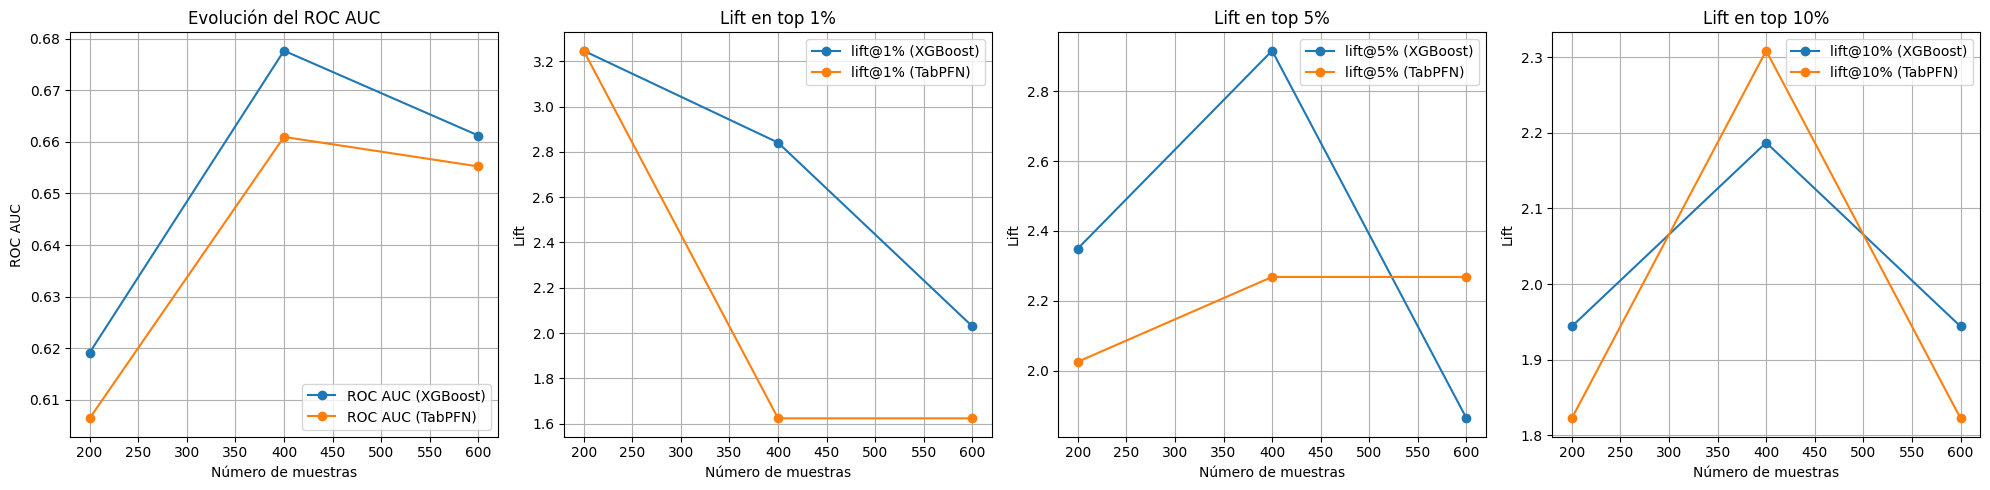

4
Shape X_train: (800, 30)
Shape y_train: (800,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 0:12:23.878217
-Métricas XGBoost-
	ROC AUC: 0.6818
	Lift @ top 1%: 4.06x
	Lift @ top 5%: 3.16x
	Lift @ top 10%: 2.67x

-Métricas TabPFN-
	ROC AUC: 0.6657
	Lift @ top 1%: 2.43x
	Lift @ top 5%: 2.43x
	Lift @ top 10%: 2.15x


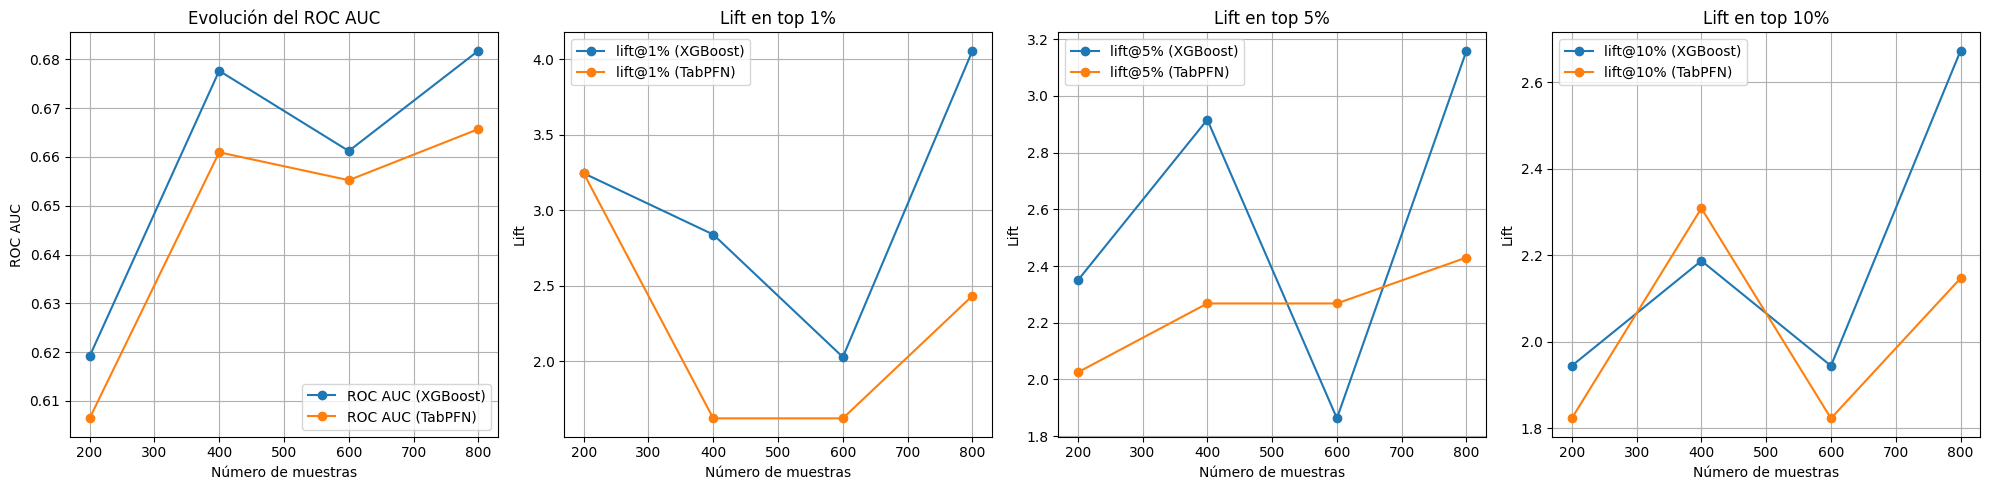

5
Shape X_train: (1000, 30)
Shape y_train: (1000,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 0:16:41.116577
-Métricas XGBoost-
	ROC AUC: 0.6913
	Lift @ top 1%: 3.25x
	Lift @ top 5%: 3.24x
	Lift @ top 10%: 2.83x

-Métricas TabPFN-
	ROC AUC: 0.6785
	Lift @ top 1%: 4.06x
	Lift @ top 5%: 2.67x
	Lift @ top 10%: 2.31x


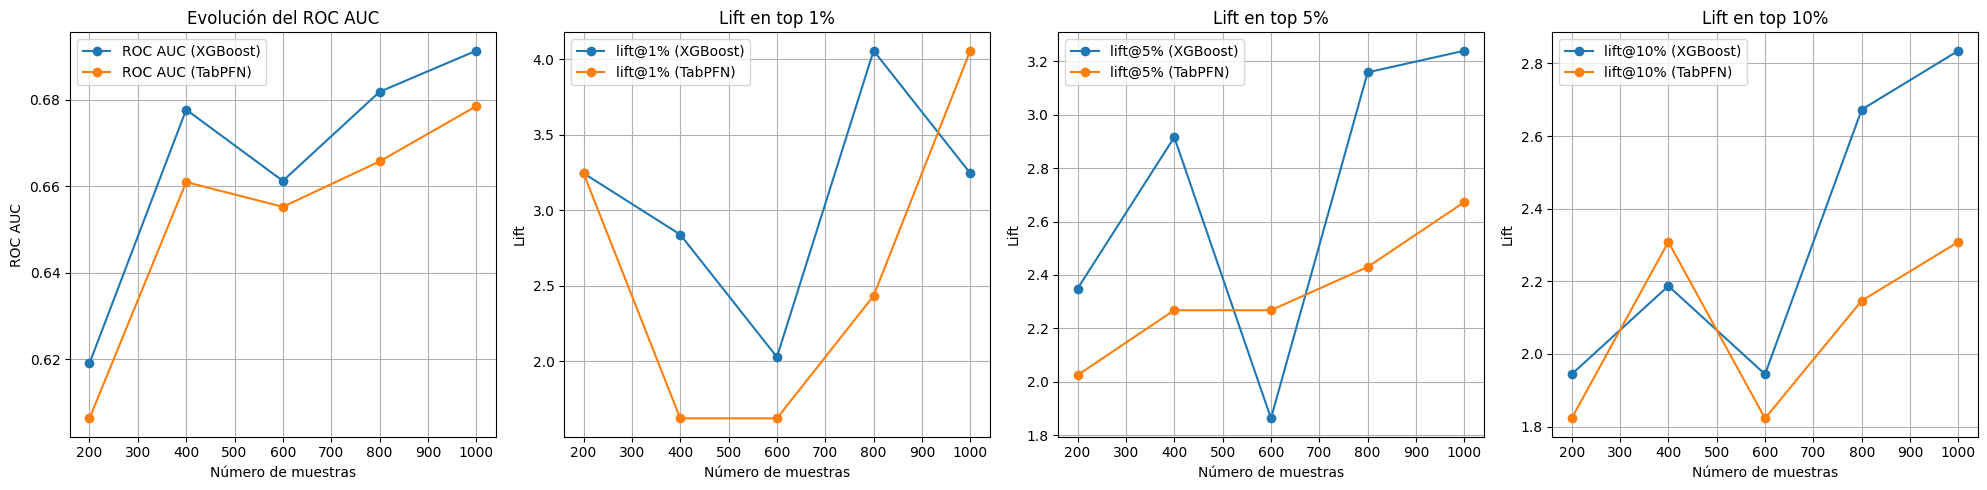

6
Shape X_train: (1200, 30)
Shape y_train: (1200,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 0:22:33.452837
-Métricas XGBoost-
	ROC AUC: 0.6945
	Lift @ top 1%: 5.68x
	Lift @ top 5%: 3.24x
	Lift @ top 10%: 2.75x

-Métricas TabPFN-
	ROC AUC: 0.6874
	Lift @ top 1%: 6.09x
	Lift @ top 5%: 2.92x
	Lift @ top 10%: 2.39x


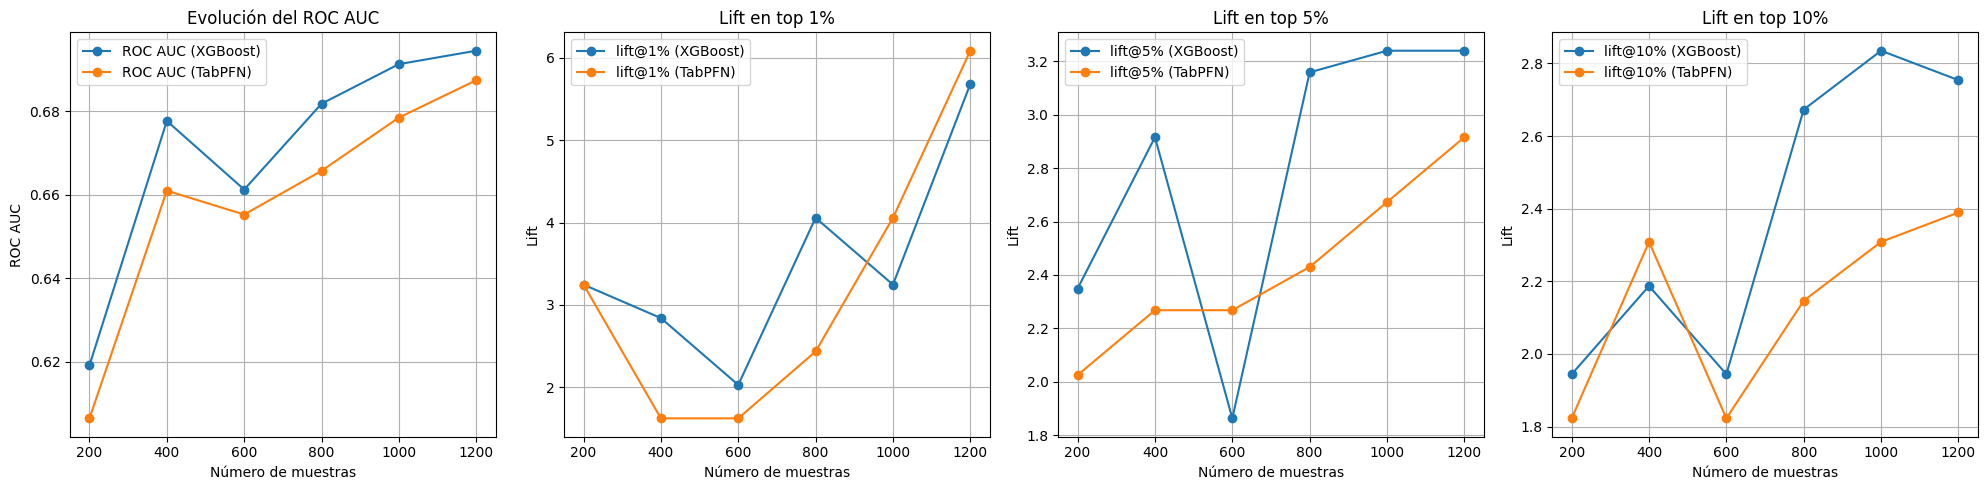

7
Shape X_train: (1400, 30)
Shape y_train: (1400,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 0:28:02.038461
-Métricas XGBoost-
	ROC AUC: 0.7024
	Lift @ top 1%: 4.46x
	Lift @ top 5%: 3.16x
	Lift @ top 10%: 2.79x

-Métricas TabPFN-
	ROC AUC: 0.6944
	Lift @ top 1%: 4.87x
	Lift @ top 5%: 3.32x
	Lift @ top 10%: 2.47x


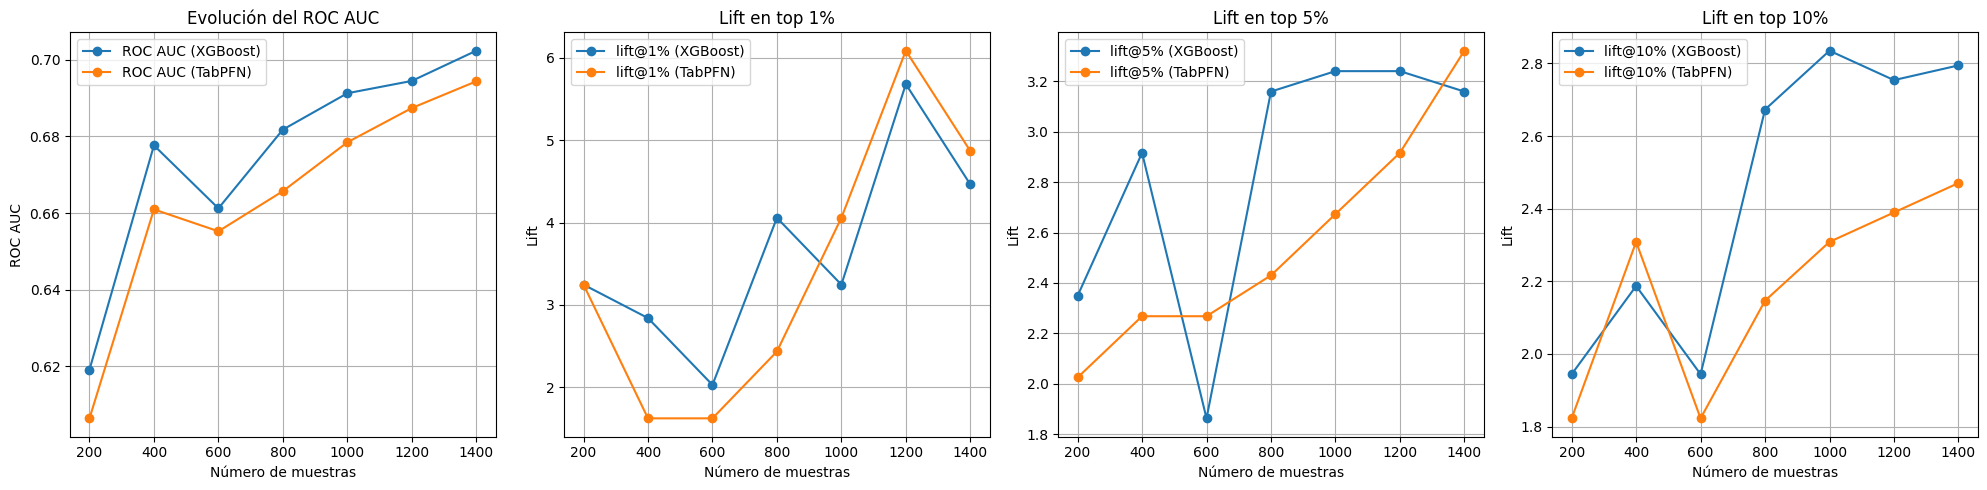

8
Shape X_train: (1600, 30)
Shape y_train: (1600,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 0:33:37.891304
-Métricas XGBoost-
	ROC AUC: 0.7063
	Lift @ top 1%: 4.87x
	Lift @ top 5%: 3.16x
	Lift @ top 10%: 2.67x

-Métricas TabPFN-
	ROC AUC: 0.7100
	Lift @ top 1%: 3.65x
	Lift @ top 5%: 2.75x
	Lift @ top 10%: 2.88x


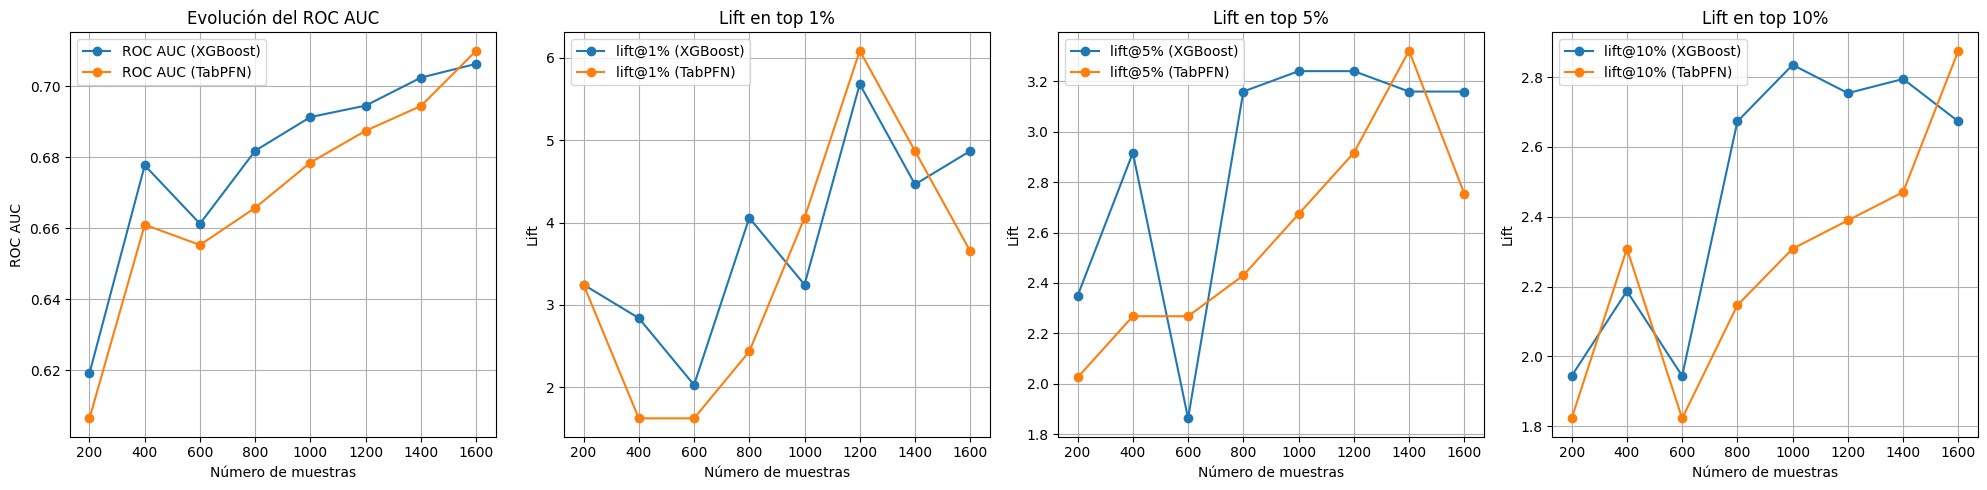

9
Shape X_train: (1800, 30)
Shape y_train: (1800,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 0:40:49.220760
-Métricas XGBoost-
	ROC AUC: 0.7073
	Lift @ top 1%: 4.87x
	Lift @ top 5%: 3.48x
	Lift @ top 10%: 2.75x

-Métricas TabPFN-
	ROC AUC: 0.7201
	Lift @ top 1%: 4.46x
	Lift @ top 5%: 3.48x
	Lift @ top 10%: 3.16x


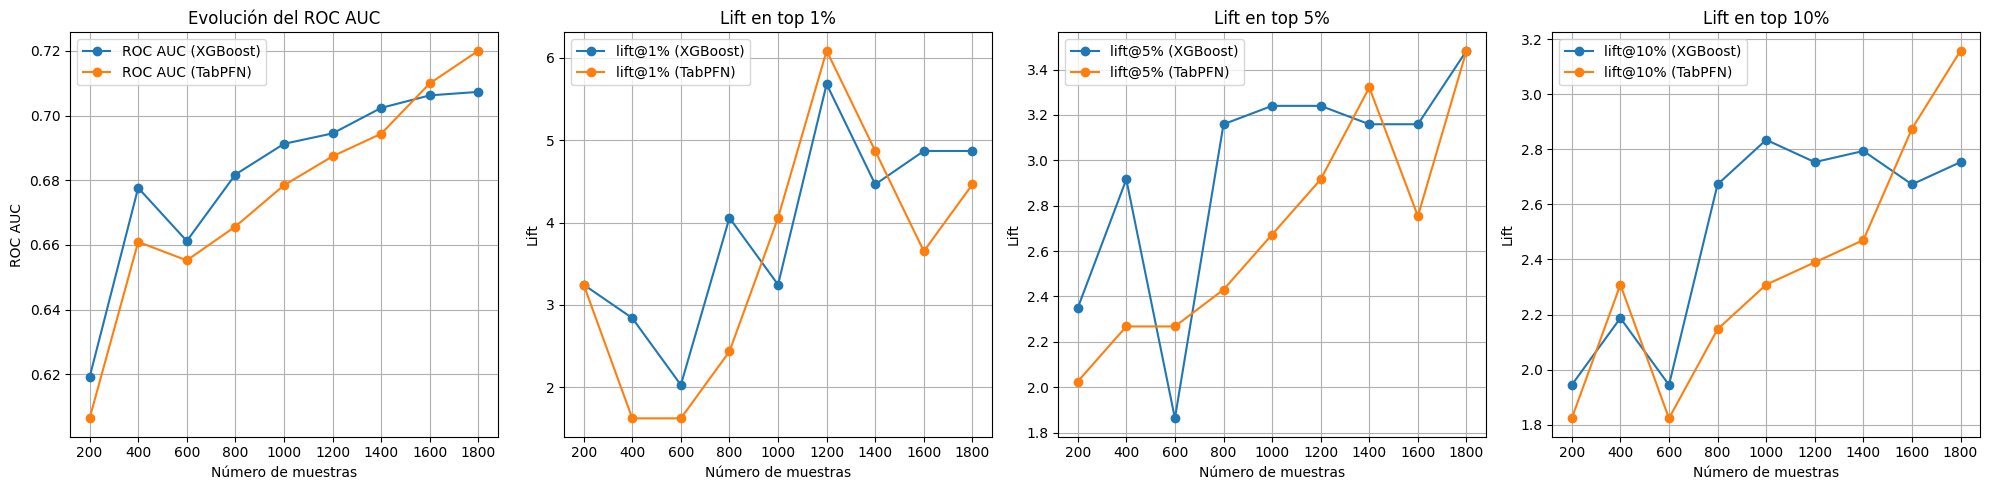

10
Shape X_train: (2000, 30)
Shape y_train: (2000,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 0:49:28.512742
-Métricas XGBoost-
	ROC AUC: 0.7039
	Lift @ top 1%: 4.46x
	Lift @ top 5%: 3.40x
	Lift @ top 10%: 2.67x

-Métricas TabPFN-
	ROC AUC: 0.7179
	Lift @ top 1%: 6.09x
	Lift @ top 5%: 3.48x
	Lift @ top 10%: 2.96x


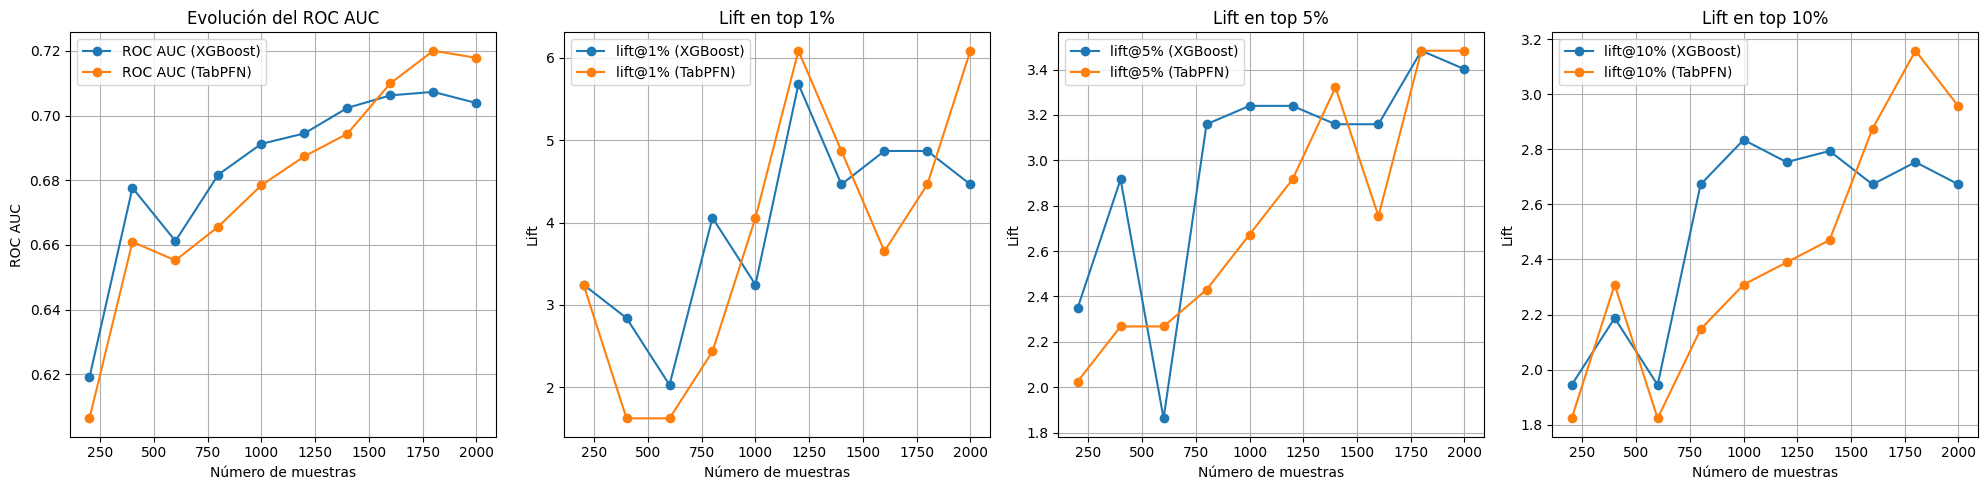

11
Shape X_train: (2200, 30)
Shape y_train: (2200,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 0:58:40.585009
-Métricas XGBoost-
	ROC AUC: 0.6966
	Lift @ top 1%: 3.65x
	Lift @ top 5%: 3.16x
	Lift @ top 10%: 2.71x

-Métricas TabPFN-
	ROC AUC: 0.7179
	Lift @ top 1%: 4.06x
	Lift @ top 5%: 3.56x
	Lift @ top 10%: 3.12x


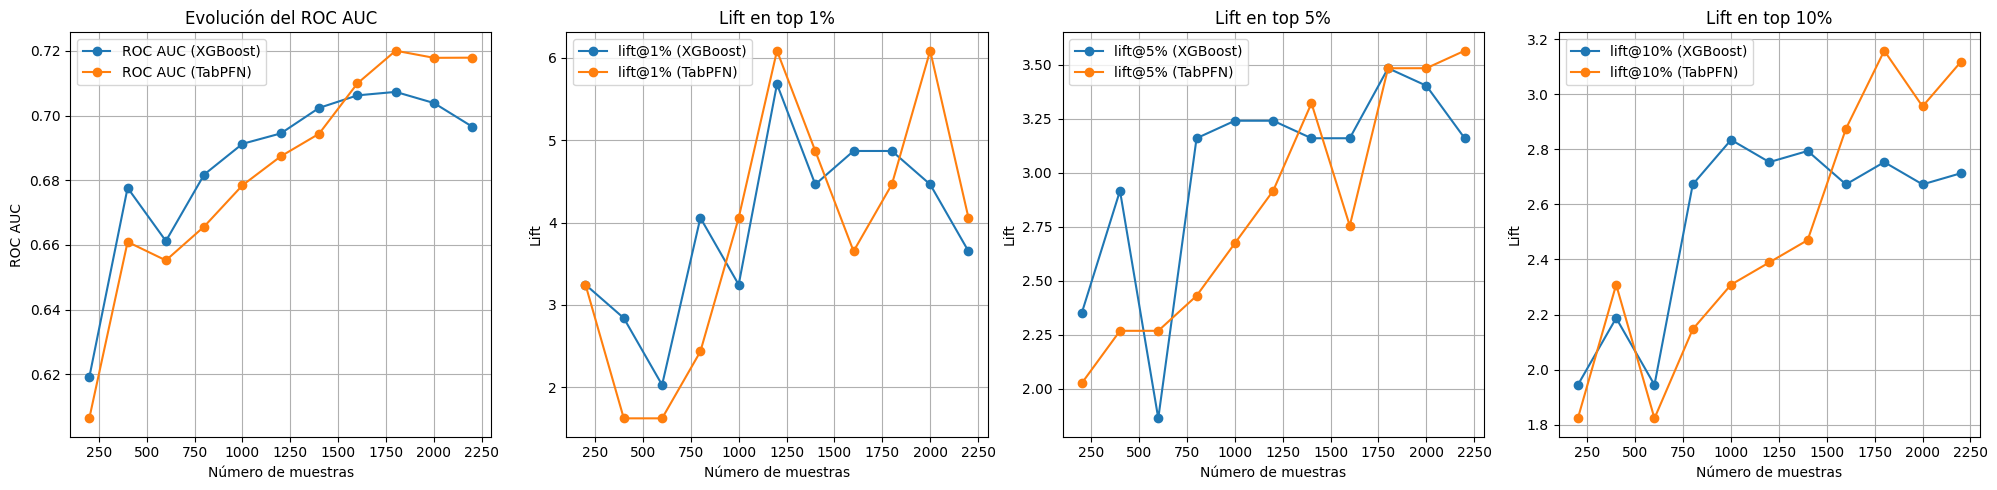

12
Shape X_train: (2400, 30)
Shape y_train: (2400,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 1:09:57.556987
-Métricas XGBoost-
	ROC AUC: 0.7004
	Lift @ top 1%: 2.84x
	Lift @ top 5%: 3.00x
	Lift @ top 10%: 2.67x

-Métricas TabPFN-
	ROC AUC: 0.7195
	Lift @ top 1%: 4.87x
	Lift @ top 5%: 3.24x
	Lift @ top 10%: 2.71x


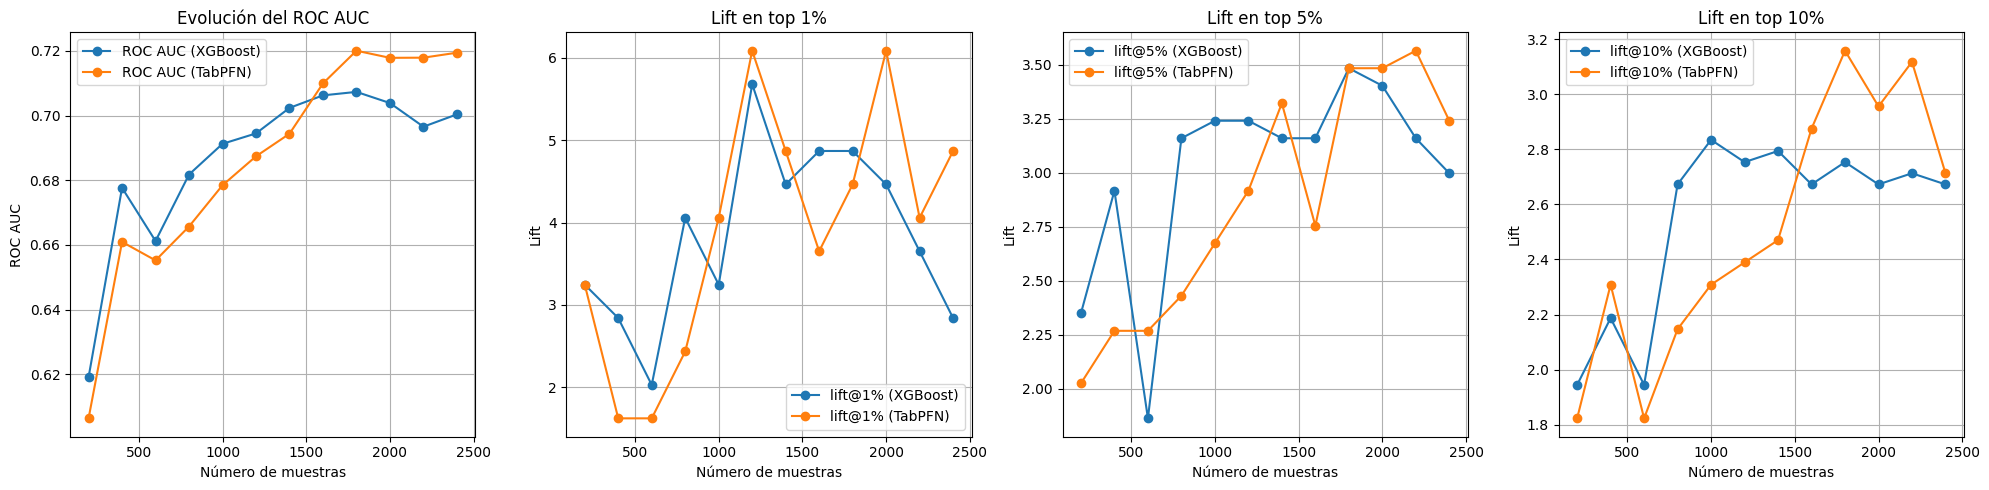

13
Shape X_train: (2600, 30)
Shape y_train: (2600,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 1:18:01.376006
-Métricas XGBoost-
	ROC AUC: 0.7100
	Lift @ top 1%: 4.87x
	Lift @ top 5%: 3.32x
	Lift @ top 10%: 2.71x

-Métricas TabPFN-
	ROC AUC: 0.7175
	Lift @ top 1%: 4.87x
	Lift @ top 5%: 3.00x
	Lift @ top 10%: 2.88x


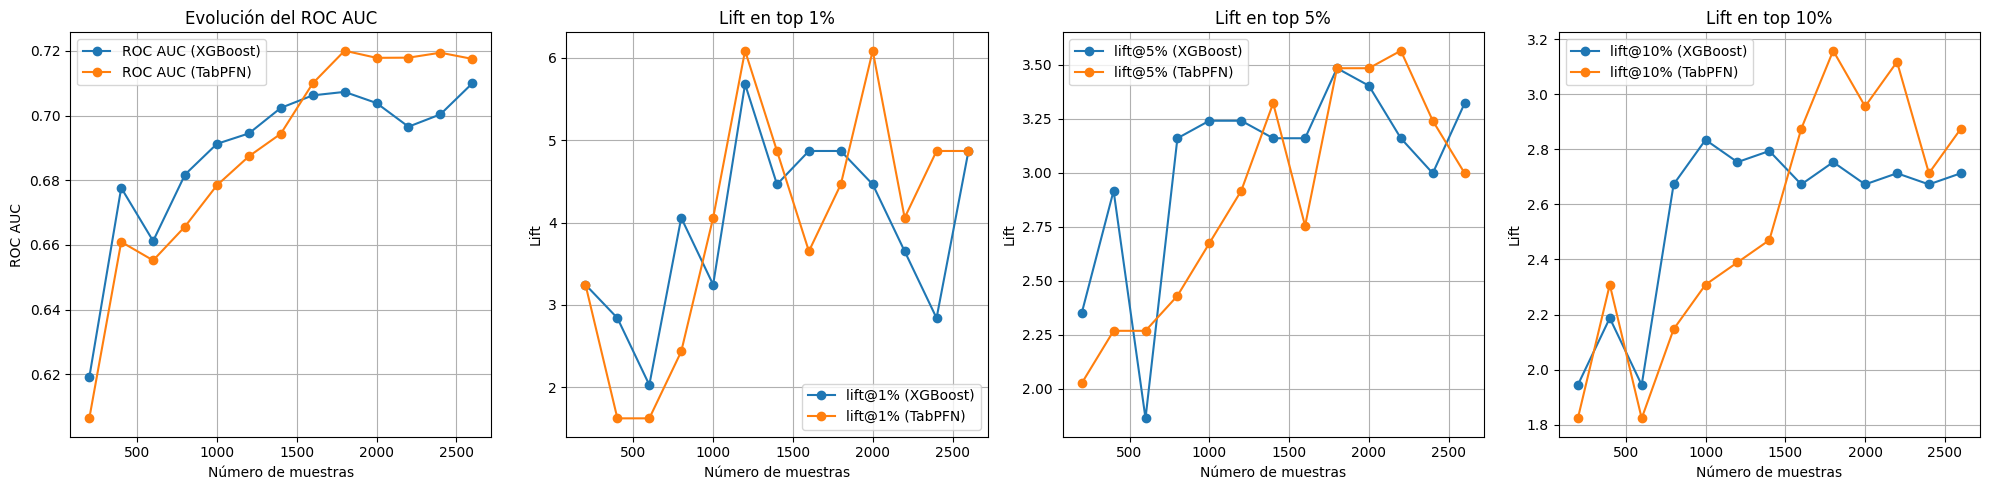

14
Shape X_train: (2800, 30)
Shape y_train: (2800,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 1:32:03.330672
-Métricas XGBoost-
	ROC AUC: 0.7122
	Lift @ top 1%: 4.06x
	Lift @ top 5%: 3.32x
	Lift @ top 10%: 2.83x

-Métricas TabPFN-
	ROC AUC: 0.7167
	Lift @ top 1%: 6.49x
	Lift @ top 5%: 2.92x
	Lift @ top 10%: 2.83x


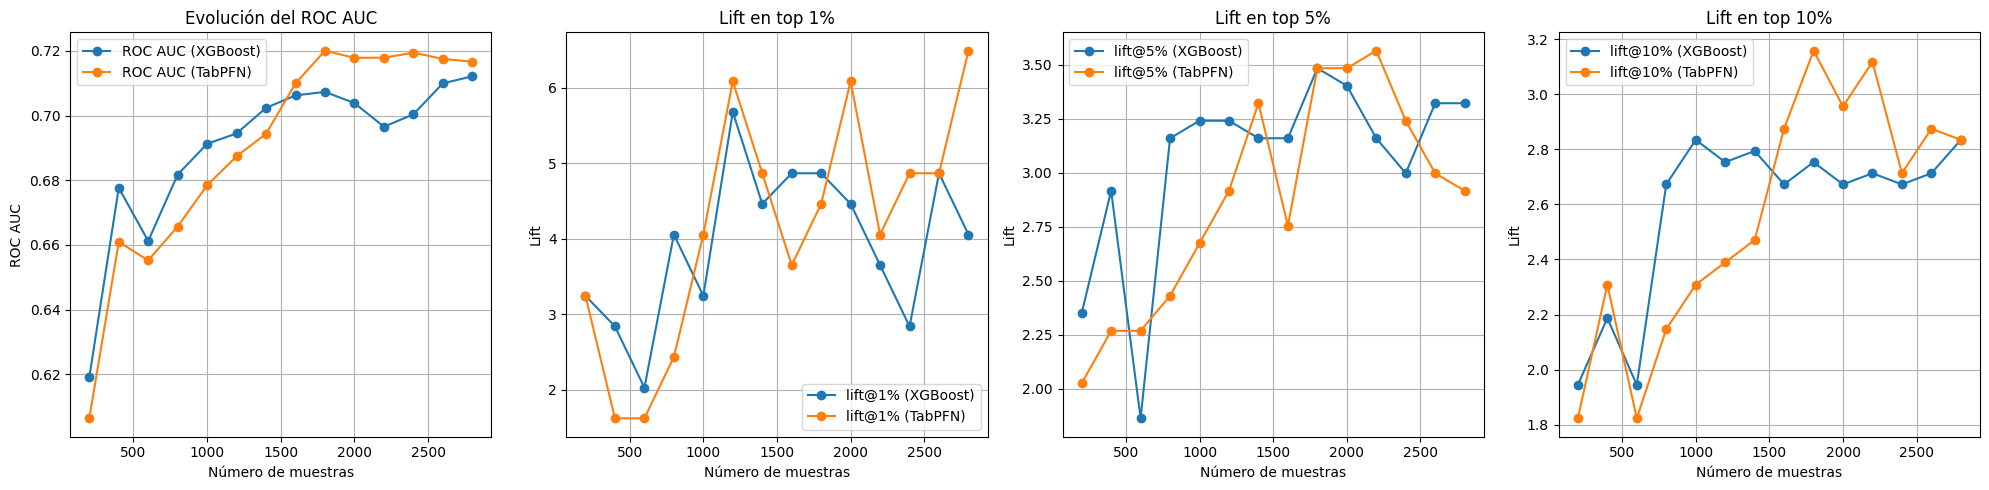

15
Shape X_train: (3000, 30)
Shape y_train: (3000,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
auc_xgb=[]
lifts_xgb=[]

auc_tabpfn=[]
lifts_tabpfn=[]

num_muestras=[]
num = [e*100 for e in range(1,25)]
for i,e in enumerate(num):
    print(i+1)
    carry = 0
    if e>df_train.filter(pl.col("target") == 1).shape[0]:
        df_positivos = df_train.filter(pl.col("target") == 1)
        carry = e-df_train.filter(pl.col("target") == 1).shape[0]
    else:
        df_positivos=df_train.filter(pl.col("target") == 1).sample(n=e, seed=42)

    df_negativos = df_train.filter(pl.col("target") == 0).sample(n=e+carry, seed=42)
    

    # Combinar ambos conjuntos
    df_sec = pl.concat([df_positivos, df_negativos])
    
    X_train = df_sec.select(cs)
    y_train = df_sec["target"]
    
    print("Shape X_train:",X_train.shape)
    print("Shape y_train:",y_train.shape)
    num_muestras.append(X_train.shape[0])
    
    
    _,xgb_m = optimizar_xgboost_bayesiana(X_train, y_train,
                                                   n_iter=30,
                                                   cv=3
                                                  )
    tabpfn_m = TabPFNClassifier(ignore_pretraining_limits=True)
    tabpfn_m.fit(X_train, y_train)
    
    y_pred_xgb_m = xgb_m.predict_proba(X_test)[:, 1]
    st=time.time()
    y_pred_tabpfn = predict_en_batches(tabpfn_m, X_test.to_pandas())
    print(f"Tiempo de inferencia TabPFN: {timedelta(seconds=time.time() - st)}")
    print("-Métricas XGBoost-")
    a_xgb, l_xgb = evaluar_modelo(y_test, y_pred_xgb_m)
    print()
    print("-Métricas TabPFN-")
    a_tabpfn, l_tabpfn = evaluar_modelo(y_test, y_pred_tabpfn)
    
    auc_xgb.append(a_xgb)
    lifts_xgb.append(l_xgb)

    auc_tabpfn.append(a_tabpfn)
    lifts_tabpfn.append(l_tabpfn)
    
    #VISUALIZACIÓN
    if i>1:
        df_metrics_xgb = pl.DataFrame({
            "n_features": num_muestras,
            "roc_auc": auc_xgb,
            "lift@1%": [x[1] for x in lifts_xgb],
            "lift@5%": [x[5] for x in lifts_xgb],
            "lift@10%": [x[10] for x in lifts_xgb]
        })

        df_metrics_tabpfn = pl.DataFrame({
            "n_features": num_muestras,
            "roc_auc": auc_tabpfn,
            "lift@1%": [x[1] for x in lifts_tabpfn],
            "lift@5%": [x[5] for x in lifts_tabpfn],
            "lift@10%": [x[10] for x in lifts_tabpfn]
        })

        graficar_metricas_comparadas(df_metrics_xgb, df_metrics_tabpfn,
                                     nombre_modelo_1="XGBoost",
                                     nombre_modelo_2="TabPFN",
                                     lift_percentiles=[1,5,10])

        

    
    

In [ ]:
# df_metrics_xgb = pl.DataFrame({
#     "n_features": num_muestras,
#     "roc_auc": auc_xgb,
#     "lift@1%": [x[1] for x in lifts_xgb],
#     "lift@5%": [x[5] for x in lifts_xgb],
#     "lift@10%": [x[10] for x in lifts_xgb]
# })

# df_metrics_tabpfn = pl.DataFrame({
#     "n_features": num_muestras,
#     "roc_auc": auc_tabpfn,
#     "lift@1%": [x[1] for x in lifts_tabpfn],
#     "lift@5%": [x[5] for x in lifts_tabpfn],
#     "lift@10%": [x[10] for x in lifts_tabpfn]
# })


In [ ]:
# graficar_metricas_comparadas(df_metrics_xgb, df_metrics_tabpfn,
#                              nombre_modelo_1="XGBoost",
#                              nombre_modelo_2="TabPFN",
#                              lift_percentiles=[1,5,10])


In [ ]:
# auc_xgb = [
#     0.6518, 0.6913, 0.6969, 0.7133, 0.7089, 0.6936, 0.6961, 0.7150, 0.7269, 0.7311,
#     0.7278, 0.7220, 0.7298, 0.7370, 0.7341, 0.7357, 0.7363, 0.7326
# ]
# lifts_xgb = [
#     {1: 0.41, 5: 0.08, 10: 2.22},
#     {1: 3.71, 5: 2.72, 10: 2.22},
#     {1: 4.12, 5: 3.13, 10: 2.59},
#     {1: 4.54, 5: 3.29, 10: 2.72},
#     {1: 5.36, 5: 2.80, 10: 2.47},
#     {1: 3.30, 5: 3.29, 10: 2.47},
#     {1: 4.12, 5: 2.88, 10: 2.47},
#     {1: 4.12, 5: 2.88, 10: 2.68},
#     {1: 4.12, 5: 3.29, 10: 3.00},
#     {1: 4.95, 5: 3.29, 10: 2.72},
#     {1: 4.54, 5: 3.29, 10: 3.00},
#     {1: 4.12, 5: 3.54, 10: 2.76},
#     {1: 4.54, 5: 3.62, 10: 2.92},
#     {1: 4.95, 5: 3.79, 10: 3.05},
#     {1: 4.95, 5: 3.29, 10: 3.00},
#     {1: 4.54, 5: 3.21, 10: 3.13},
#     {1: 6.19, 5: 3.37, 10: 3.09},
#     {1: 5.36, 5: 3.70, 10: 3.00}
# ]

# auc_tabpfn = [
#     0.6849, 0.6810, 0.7001, 0.7017, 0.7053, 0.7259, 0.7200, 0.7303, 0.7309, 0.7334,
#     0.7341, 0.7353, 0.7387, 0.7400, 0.7401, 0.7411, 0.7426, 0.7417
# ]

# lifts_tabpfn = [ 
#     {1: 2.06, 5: 2.47, 10: 2.39},
#     {1: 1.65, 5: 1.65, 10: 2.39},
#     {1: 1.65, 5: 2.39, 10: 2.35},
#     {1: 3.71, 5: 2.47, 10: 2.76},
#     {1: 3.71, 5: 3.05, 10: 2.43},
#     {1: 7.01, 5: 3.37, 10: 2.84},
#     {1: 5.36, 5: 3.13, 10: 2.68},
#     {1: 5.36, 5: 2.96, 10: 2.88},
#     {1: 4.95, 5: 2.80, 10: 2.72},
#     {1: 4.54, 5: 3.37, 10: 2.80},
#     {1: 4.54, 5: 3.29, 10: 2.88},
#     {1: 4.12, 5: 3.37, 10: 2.68},
#     {1: 4.95, 5: 3.37, 10: 2.84},
#     {1: 4.12, 5: 3.21, 10: 2.88},
#     {1: 4.54, 5: 3.29, 10: 2.88},
#     {1: 4.54, 5: 3.13, 10: 2.84},
#     {1: 4.95, 5: 3.05, 10: 2.92},
#     {1: 4.12, 5: 3.21, 10: 2.96}
# ]

# num_muestras = [
#     200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000,
#     2200, 2355, 2455, 2555, 2655, 2755, 2855, 2955
# ]
